In [1]:
# Cell 1: Setup and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_ind, shapiro, levene

# Make warnings less noisy
import warnings
warnings.filterwarnings('ignore')

# Make our plots look nice
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries loaded successfully!")
print(f"Pandas version: {pd.__version__}")

✅ Libraries loaded successfully!
Pandas version: 2.2.2


In [2]:
control = pd.read_csv('/content/control_group.csv', sep=';')
test = pd.read_csv('/content/test_group.csv', sep=';')


display(control.head(3))

display(test.head(3))

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0


,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578


In [3]:
# Cell 3: Data Quality Assessment

# Check data types

print(control.dtypes)

# Check for missing values

missing_control = control.isnull().sum()
print(missing_control[missing_control > 0])


missing_test = test.isnull().sum()
print(missing_test[missing_test > 0])

# Check for duplicates

print(f"Control group: {control.duplicated().sum()} duplicates")
print(f"Test group: {test.duplicated().sum()} duplicates")

print(control[control['# of Impressions'].isnull()])

Campaign Name           object
Date                    object
Spend [USD]              int64
# of Impressions       float64
Reach                  float64
# of Website Clicks    float64
# of Searches          float64
# of View Content      float64
# of Add to Cart       float64
# of Purchase          float64
dtype: object
# of Impressions       1
Reach                  1
# of Website Clicks    1
# of Searches          1
# of View Content      1
# of Add to Cart       1
# of Purchase          1
dtype: int64
Series([], dtype: int64)
Control group: 0 duplicates
Test group: 0 duplicates
      Campaign Name       Date  Spend [USD]  # of Impressions  Reach  \
4  Control Campaign  5.08.2019         1835               NaN    NaN   

   # of Website Clicks  # of Searches  # of View Content  # of Add to Cart  \
4                  NaN            NaN                NaN               NaN   

   # of Purchase  
4            NaN  


In [4]:
# Cell 4: Data Cleaning

# 1. Convert Date column from text to actual datetime
control['Date'] = pd.to_datetime(control['Date'], format='%d.%m.%Y')
test['Date'] = pd.to_datetime(test['Date'], format='%d.%m.%Y')

# 2. Add a column to identify which group each row belongs to
control['Group'] = 'Control'
test['Group'] = 'Test'

# 3. Remove rows with missing critical data (the row with no impressions)
control_clean = control.dropna(subset=['# of Impressions'])

# 4. Combine both datasets into one for easier analysis
df = pd.concat([control_clean, test], ignore_index=True)


display(df.head())

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase,Group
0,Control Campaign,2019-08-01,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0,Control
1,Control Campaign,2019-08-02,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0,Control
2,Control Campaign,2019-08-03,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0,Control
3,Control Campaign,2019-08-04,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0,Control
4,Control Campaign,2019-08-06,3083,109076.0,87998.0,4028.0,1709.0,1249.0,784.0,764.0,Control


In [5]:
# Cell 5: Feature Engineering - Calculate Marketing Metrics



# PRIMARY METRICS
# CTR = Click-Through Rate
df['CTR'] = (df['# of Website Clicks'] / df['# of Impressions']) * 100

# CPM = Cost Per Mille
df['CPM'] = (df['Spend [USD]'] / df['# of Impressions']) * 1000

# CPC = Cost Per Click
df['CPC'] = df['Spend [USD]'] / df['# of Website Clicks']

# CPA = Cost Per Acquisition
df['CPA'] = df['Spend [USD]'] / df['# of Purchase']

# Overall Conversion Rate
df['Conversion_Rate'] = (df['# of Purchase'] / df['# of Impressions']) * 100

# FUNNEL METRICS (how well does each stage convert?)
df['Click_to_Search_Rate'] = (df['# of Searches'] / df['# of Website Clicks']) * 100
df['Search_to_View_Rate'] = (df['# of View Content'] / df['# of Searches']) * 100
df['View_to_Cart_Rate'] = (df['# of Add to Cart'] / df['# of View Content']) * 100
df['Cart_to_Purchase_Rate'] = (df['# of Purchase'] / df['# of Add to Cart']) * 100

# ROAS = Return on Ad Spend
AVERAGE_ORDER_VALUE = 50
df['Revenue'] = df['# of Purchase'] * AVERAGE_ORDER_VALUE
df['ROAS'] = df['Revenue'] / df['Spend [USD]']
df['ROI'] = ((df['Revenue'] - df['Spend [USD]']) / df['Spend [USD]']) * 100

# Handle infinity values (when dividing by zero)
df.replace([np.inf, -np.inf], np.nan, inplace=True)


display(df[['Group', 'Date', 'CTR', 'CPA', 'Conversion_Rate', 'ROAS']].head())

,Group,Date,CTR,CPA,Conversion_Rate,ROAS
0,Control,2019-08-01,8.483471,3.689320,0.747261,13.552632
1,Control,2019-08-02,6.700264,3.438356,0.422174,14.541833
2,Control,2019-08-03,4.941121,6.298387,0.282437,7.938540
3,Control,2019-08-04,4.205659,5.705882,0.466533,8.762887
4,Control,2019-08-06,3.692838,4.035340,0.700429,12.390529


In [7]:
# Cell 6: Exploratory Data Analysis - Group Comparison

# Select metrics to compare
metrics_to_compare = [
    '# of Impressions', '# of Website Clicks', '# of Searches',
    '# of View Content', '# of Add to Cart', '# of Purchase',
    'CTR', 'CPC', 'CPA', 'Conversion_Rate', 'ROAS', 'ROI'
]

# Calculate means for each group
comparison = df.groupby('Group')[metrics_to_compare].mean()

# Add difference and percentage change
comparison = comparison.T
comparison['Difference'] = comparison['Test'] - comparison['Control']
comparison['% Change'] = (comparison['Difference'] / comparison['Control']) * 100

display(comparison.round(2))

# Highlight the biggest changes
big_changes = comparison[abs(comparison['% Change']) > 10].sort_values('% Change', ascending=False)
for metric, row in big_changes.iterrows():
    print(f"{metric:30s}: {row['% Change']:6.1f}%")

# summary statistics

display(df[df['Group']=='Control'][metrics_to_compare].describe().round(2))

display(df[df['Group']=='Test'][metrics_to_compare].describe().round(2))

Group,Control,Test,Difference,% Change
# of Impressions,109559.76,74584.80,-34974.96,-31.92
# of Website Clicks,5320.79,6032.33,711.54,13.37
# of Searches,2221.31,2418.97,197.66,8.90
# of View Content,1943.79,1858.00,-85.79,-4.41
# of Add to Cart,1300.00,881.53,-418.47,-32.19
# of Purchase,522.79,521.23,-1.56,-0.30
CTR,5.10,10.24,5.15,100.99
CPC,0.49,0.47,-0.03,-5.29
CPA,5.05,5.90,0.85,16.77
Conversion_Rate,0.50,0.84,0.34,68.48


CTR                           :  101.0%
Conversion_Rate               :   68.5%
CPA                           :   16.8%
# of Website Clicks           :   13.4%
ROAS                          :  -11.0%
ROI                           :  -12.0%
# of Impressions              :  -31.9%
# of Add to Cart              :  -32.2%


,# of Impressions,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase,CTR,CPC,CPA,Conversion_Rate,ROAS,ROI
count,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00
mean,109559.76,5320.79,2221.31,1943.79,1300.00,522.79,5.10,0.49,5.05,0.50,11.60,1060.21
std,21688.92,1757.37,866.09,777.55,407.46,185.03,2.05,0.22,2.12,0.22,4.56,456.36
min,71274.00,2277.00,1001.00,848.00,442.00,222.00,1.86,0.22,2.25,0.19,5.10,409.88
25%,92029.00,4085.00,1615.00,1249.00,930.00,372.00,3.62,0.33,3.44,0.35,7.94,693.85
50%,113430.00,5224.00,2390.00,1984.00,1339.00,501.00,4.72,0.42,4.62,0.47,10.82,982.02
75%,121332.00,6628.00,2711.00,2421.00,1641.00,670.00,6.70,0.57,6.30,0.61,14.54,1354.18
max,145248.00,8137.00,4891.00,4219.00,1913.00,800.00,8.83,1.04,9.81,1.07,22.19,2118.52


,# of Impressions,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase,CTR,CPC,CPA,Conversion_Rate,ROAS,ROI
count,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00
mean,74584.80,6032.33,2418.97,1858.00,881.53,521.23,10.24,0.47,5.90,0.84,10.33,932.89
std,32121.38,1708.57,388.74,597.65,347.58,211.05,6.77,0.18,2.80,0.52,4.40,439.94
min,22521.00,3038.00,1854.00,858.00,278.00,238.00,2.98,0.25,2.43,0.18,3.94,293.64
25%,47541.25,4407.00,2043.00,1320.00,582.50,298.00,5.31,0.33,3.73,0.48,6.48,547.77
50%,68853.50,6242.50,2395.50,1881.00,974.00,500.00,8.04,0.45,5.06,0.68,9.88,887.61
75%,99500.00,7604.75,2801.25,2412.00,1148.50,701.00,12.85,0.60,7.72,1.11,13.42,1242.31
max,133771.00,8264.00,2978.00,2801.00,1391.00,890.00,33.82,0.99,12.70,2.27,20.59,1958.82


In [9]:
# Cell 7: Statistical Hypothesis Testing

def perform_ab_test(control_data, test_data, metric_name):
    """
    Performs a complete statistical test on one metric.

    Steps:
    1. Test if data is normally distributed (Shapiro-Wilk test)
    2. Test if variances are equal (Levene test)
    3. Choose appropriate test (t-test or Mann-Whitney U)
    4. Calculate effect size (Cohen's d)
    """

    # Remove missing values
    control_clean = control_data.dropna()
    test_clean = test_data.dropna()

    # Need at least 3 samples
    if len(control_clean) < 3 or len(test_clean) < 3:
        return None

    # Basic statistics
    n_control = len(control_clean)
    n_test = len(test_clean)
    mean_control = control_clean.mean()
    mean_test = test_clean.mean()
    std_control = control_clean.std()
    std_test = test_clean.std()

    # Step 1: Test for normality
    _, p_normal_control = shapiro(control_clean)
    _, p_normal_test = shapiro(test_clean)
    is_normal = (p_normal_control > 0.05) and (p_normal_test > 0.05)

    # Step 2: Test for equal variances
    _, p_variance = levene(control_clean, test_clean)
    equal_var = p_variance > 0.05

    # Step 3: Choose and perform appropriate test
    if is_normal and equal_var:
        # Use t-test (parametric)
        stat, p_value = ttest_ind(control_clean, test_clean)
        test_name = "Independent T-Test"
    else:
        # Use Mann-Whitney U (non-parametric, more robust)
        stat, p_value = mannwhitneyu(control_clean, test_clean, alternative='two-sided')
        test_name = "Mann-Whitney U Test"

    # Step 4: Calculate effect size (Cohen's d)
    pooled_std = np.sqrt((std_control**2 + std_test**2) / 2)
    cohens_d = (mean_test - mean_control) / pooled_std if pooled_std > 0 else 0

    return {
        'metric': metric_name,
        'control_mean': mean_control,
        'test_mean': mean_test,
        'difference': mean_test - mean_control,
        'pct_change': ((mean_test - mean_control) / mean_control * 100) if mean_control != 0 else np.nan,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'significant': p_value < 0.05,
        'test_used': test_name,
        'is_normal': is_normal,
        'equal_variance': equal_var
    }

# Separate groups
control_group = df[df['Group'] == 'Control']
test_group = df[df['Group'] == 'Test']

# Test key metrics
key_metrics = [
    '# of Purchase',
    'Conversion_Rate',
    'CTR',
    'CPA',
    'ROAS'
]

results = []
for metric in key_metrics:
    result = perform_ab_test(control_group[metric], test_group[metric], metric)
    if result:
        results.append(result)

results_df = pd.DataFrame(results)

# Display summary of results
display(results_df[['metric', 'control_mean', 'test_mean', 'pct_change', 'p_value', 'cohens_d', 'significant', 'test_used']])

,metric,control_mean,test_mean,pct_change,p_value,cohens_d,significant,test_used
0,# of Purchase,522.793103,521.233333,-0.298353,0.957675,-0.007859,False,Mann-Whitney U Test
1,Conversion_Rate,0.500084,0.842521,68.475871,0.004063,0.857303,True,Mann-Whitney U Test
2,CTR,5.095871,10.242260,100.991349,0.000251,1.028756,True,Mann-Whitney U Test
3,CPA,5.052339,5.899589,16.769476,0.271662,0.341283,False,Mann-Whitney U Test
4,ROAS,11.602095,10.328873,-10.974067,0.279806,-0.284056,False,Independent T-Test


In [10]:
# Cell 8: Multiple Testing Correction

# Original significance level (alpha)
alpha_original = 0.05

# Number of statistical tests performed
n_tests = len(results_df)

# Calculate the new, more stringent alpha using Bonferroni correction
# This helps to control the family-wise error rate when multiple tests are done.
alpha_bonferroni = alpha_original / n_tests

# Apply the Bonferroni correction to determine significance
# A p-value must be lower than this new alpha to be considered significant.
results_df['significant_bonferroni'] = results_df['p_value'] < alpha_bonferroni

print(f"\n📊 RESULTS AFTER BONFERRONI CORRECTION (α={alpha_bonferroni:.4f}):\n")

# Display metrics that are still significant after correction
significant_after_correction = results_df[results_df['significant_bonferroni']]

if not significant_after_correction.empty:
    print("🎯 ROBUST FINDINGS (metrics that remain statistically significant after correction):\n")
    for _, row in significant_after_correction.iterrows():
        print(f"   ✓ {row['metric']:25s} (p={row['p_value']:.6f})")
else:
    print("   ✗ No metrics remained statistically significant after Bonferroni correction.\n")

print(f"Total metrics tested: {n_tests}")
print(f"Metrics originally significant (p < {alpha_original}): {results_df['significant'].sum()}")
print(f"Metrics significant after Bonferroni correction (p < {alpha_bonferroni:.4f}): {results_df['significant_bonferroni'].sum()}")


📊 RESULTS AFTER BONFERRONI CORRECTION (α=0.0100):

🎯 ROBUST FINDINGS (metrics that remain statistically significant after correction):

   ✓ Conversion_Rate           (p=0.004063)
   ✓ CTR                       (p=0.000251)
Total metrics tested: 5
Metrics originally significant (p < 0.05): 2
Metrics significant after Bonferroni correction (p < 0.0100): 2


In [11]:
# Cell 9: Bayesian A/B Testing

def bayesian_ab_test(control_success, control_total, test_success, test_total):
    """Calculate probability that Test is better than Control"""

    # Simulate from Beta distributions
    np.random.seed(42)
    samples_control = np.random.beta(1 + control_success, 1 + control_total - control_success, 100000)
    samples_test = np.random.beta(1 + test_success, 1 + test_total - test_success, 100000)

    # Calculate metrics
    prob_test_better = (samples_test > samples_control).mean()
    lift = ((samples_test - samples_control) / samples_control) * 100

    return {
        'probability': prob_test_better,
        'expected_lift': lift.mean(),
        'ci_lower': np.percentile(lift, 2.5),
        'ci_upper': np.percentile(lift, 97.5)
    }

# Run analysis
control_impressions = control_group['# of Impressions'].sum()
control_purchases = control_group['# of Purchase'].sum()
test_impressions = test_group['# of Impressions'].sum()
test_purchases = test_group['# of Purchase'].sum()

result = bayesian_ab_test(
    int(control_purchases), int(control_impressions),
    int(test_purchases), int(test_impressions)
)

# Display results

print("BAYESIAN A/B TEST RESULTS")

print(f"\nProbability Test > Control: {result['probability']:.1%}")
print(f"Expected Lift: {result['expected_lift']:.1f}%")
print(f"95% Confidence: [{result['ci_lower']:.1f}%, {result['ci_upper']:.1f}%]")

# Decision
if result['probability'] > 0.95:
    print(f"\n✅ STRONG EVIDENCE - Implement Test variant")
elif result['probability'] > 0.90:
    print(f"\n⚠️  MODERATE EVIDENCE - Consider gradual rollout")
else:
    print(f"\n❌ WEAK EVIDENCE - Need more data or keep Control")

BAYESIAN A/B TEST RESULTS

Probability Test > Control: 100.0%
Expected Lift: 46.5%
95% Confidence: [43.2%, 49.8%]

✅ STRONG EVIDENCE - Implement Test variant


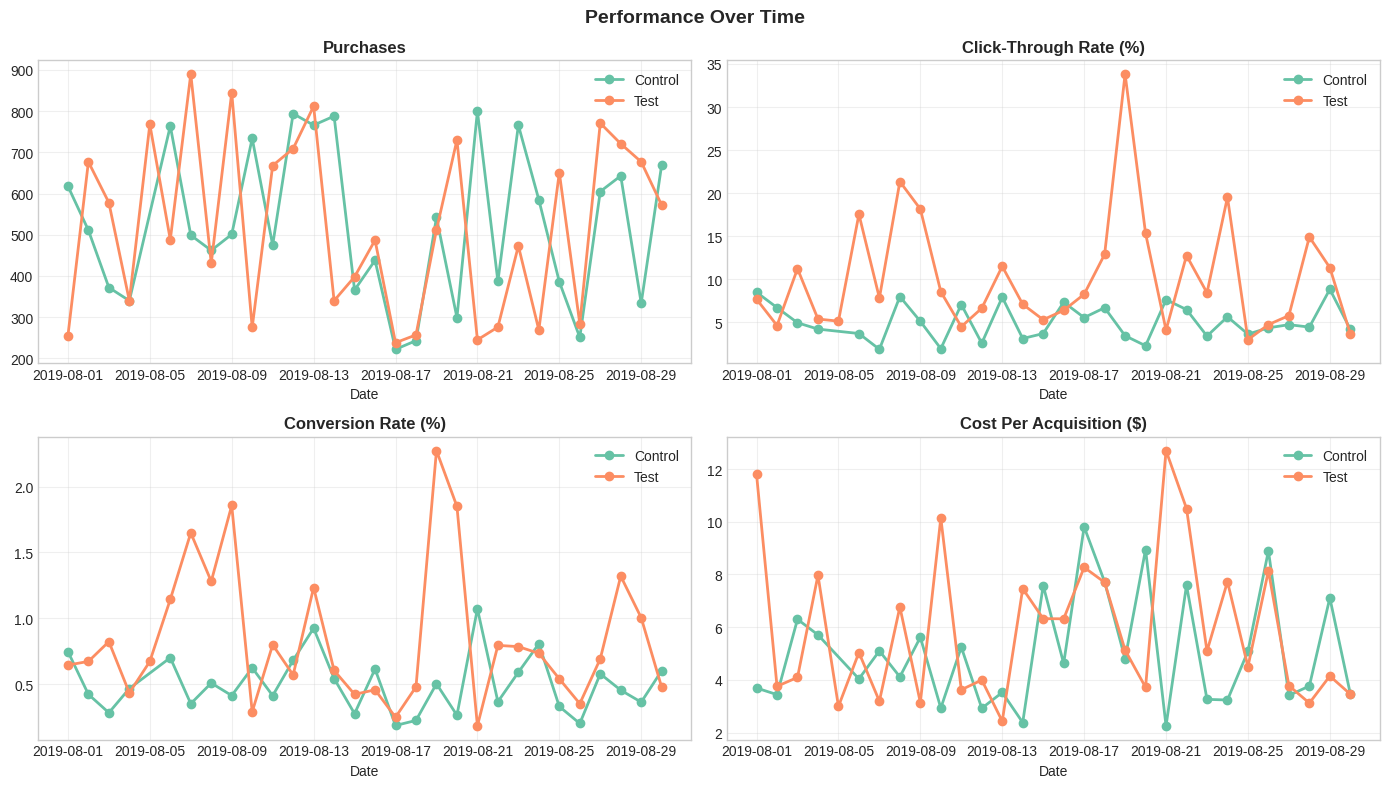

In [12]:
# Cell 10: Time Series Trends

# Aggregate daily data
daily = df.groupby(['Date', 'Group']).agg({
    '# of Purchase': 'sum',
    'Conversion_Rate': 'mean',
    'CTR': 'mean',
    'CPA': 'mean'
}).reset_index()

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Performance Over Time', fontsize=14, fontweight='bold')

metrics = [
    ('# of Purchase', 'Purchases', axes[0,0]),
    ('CTR', 'Click-Through Rate (%)', axes[0,1]),
    ('Conversion_Rate', 'Conversion Rate (%)', axes[1,0]),
    ('CPA', 'Cost Per Acquisition ($)', axes[1,1])
]

for metric, title, ax in metrics:
    for group in ['Control', 'Test']:
        data = daily[daily['Group'] == group]
        ax.plot(data['Date'], data[metric], marker='o', label=group, linewidth=2)

    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Date')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


,Stage,Control,Test,Difference,% Change
0,Impressions,3177233.0,2237544.0,-939689.0,-30.0
1,Clicks,154303.0,180970.0,26667.0,17.0
2,Searches,64418.0,72569.0,8151.0,13.0
3,Views,56370.0,55740.0,-630.0,-1.0
4,Carts,37700.0,26446.0,-11254.0,-30.0
5,Purchases,15161.0,15637.0,476.0,3.0


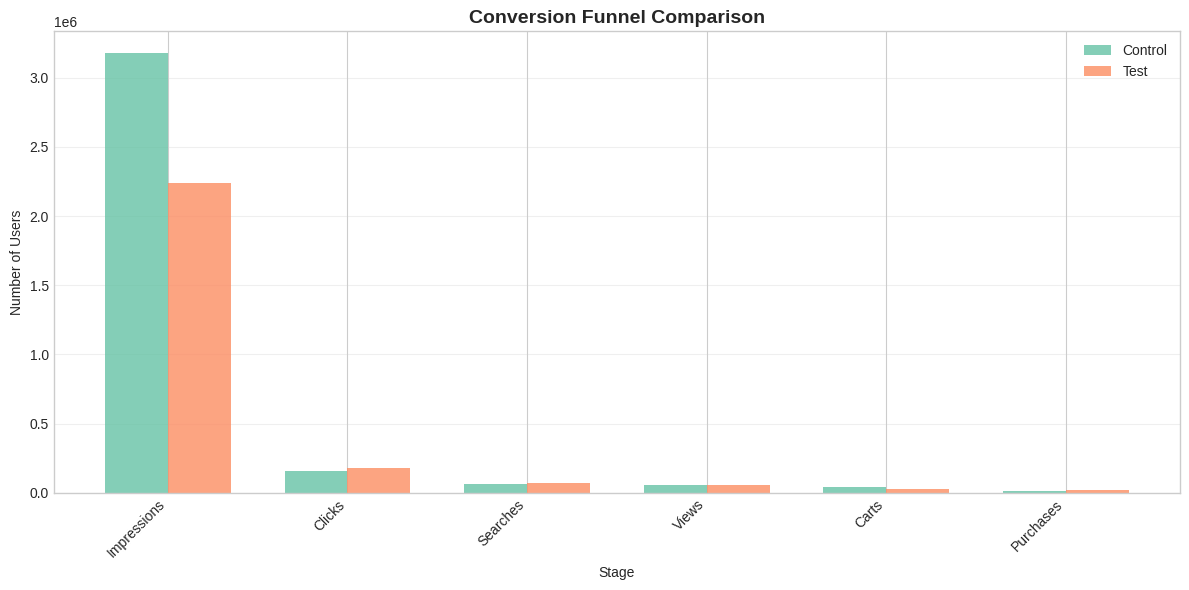

In [14]:
# Cell 11: Conversion Funnel Analysis

# Calculate funnel for each group
funnel_stages = ['Impressions', 'Clicks', 'Searches', 'Views', 'Carts', 'Purchases']
funnel_cols = ['# of Impressions', '# of Website Clicks', '# of Searches',
               '# of View Content', '# of Add to Cart', '# of Purchase']

control_values = [control_group[col].sum() for col in funnel_cols]
test_values = [test_group[col].sum() for col in funnel_cols]

# Create comparison table
funnel_df = pd.DataFrame({
    'Stage': funnel_stages,
    'Control': control_values,
    'Test': test_values
})
funnel_df['Difference'] = funnel_df['Test'] - funnel_df['Control']
funnel_df['% Change'] = (funnel_df['Difference'] / funnel_df['Control']) * 100


display(funnel_df.round(0))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(funnel_stages))
width = 0.35

ax.bar(x - width/2, control_values, width, label='Control', alpha=0.8)
ax.bar(x + width/2, test_values, width, label='Test', alpha=0.8)

ax.set_xlabel('Stage')
ax.set_ylabel('Number of Users')
ax.set_title('Conversion Funnel Comparison', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(funnel_stages, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



,Metric,Control,Test
0,Ad Spend,"$66,818","$76,892"
1,Purchases,"15,161.0","15,637.0"
2,Revenue,"$758,050","$781,850"
3,Profit,"$691,232","$704,958"
4,CPA,$4.41,$4.92
5,ROI (%),1034.5%,916.8%



📊 Incremental Impact:
   Daily Profit Increase: $473.31
   Projected Annual Impact: $172,758.28


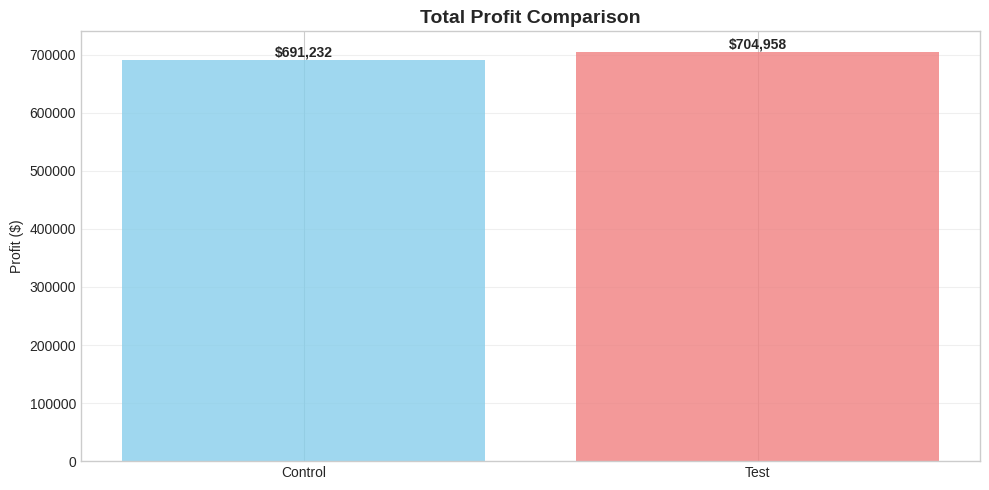

In [15]:
# Cell 12: Financial Impact

AVERAGE_ORDER_VALUE = 50

# Calculate financials
control_spend = control_group['Spend [USD]'].sum()
control_purchases_total = control_group['# of Purchase'].sum()
test_spend = test_group['Spend [USD]'].sum()
test_purchases_total = test_group['# of Purchase'].sum()

control_revenue = control_purchases_total * AVERAGE_ORDER_VALUE
test_revenue = test_purchases_total * AVERAGE_ORDER_VALUE
control_profit = control_revenue - control_spend
test_profit = test_revenue - test_spend

# Create summary table
financial_summary = pd.DataFrame({
    'Metric': ['Ad Spend', 'Purchases', 'Revenue', 'Profit', 'CPA', 'ROI (%)'],
    'Control': [
        f"${control_spend:,.0f}",
        f"{control_purchases_total:,}",
        f"${control_revenue:,.0f}",
        f"${control_profit:,.0f}",
        f"${control_spend/control_purchases_total:.2f}",
        f"{(control_profit/control_spend)*100:.1f}%"
    ],
    'Test': [
        f"${test_spend:,.0f}",
        f"{test_purchases_total:,}",
        f"${test_revenue:,.0f}",
        f"${test_profit:,.0f}",
        f"${test_spend/test_purchases_total:.2f}",
        f"{(test_profit/test_spend)*100:.1f}%"
    ]
})

display(financial_summary)

# Incremental impact
incremental_profit = test_profit - control_profit
days_tested = len(control_group)
annual_projection = (incremental_profit / days_tested) * 365

print(f"\n📊 Incremental Impact:")
print(f"   Daily Profit Increase: ${incremental_profit/days_tested:,.2f}")
print(f"   Projected Annual Impact: ${annual_projection:,.2f}")

# Simple bar chart
fig, ax = plt.subplots(figsize=(10, 5))
categories = ['Control', 'Test']
profits = [control_profit, test_profit]
colors = ['skyblue', 'lightcoral']

ax.bar(categories, profits, color=colors, alpha=0.8)
ax.set_ylabel('Profit ($)')
ax.set_title('Total Profit Comparison', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(profits):
    ax.text(i, v, f'${v:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [18]:
# Cell 13: Final Recommendation

# Score the evidence (out of 8 points)
score = 0

# 1. Bayesian probability (0-3 points)
if result['probability'] > 0.95:
    score += 3
elif result['probability'] > 0.90:
    score += 2

# 2. Statistical significance (0-2 points)
sig_count = results_df['significant_bonferroni'].sum()
if sig_count >= 3:
    score += 2
elif sig_count >= 1:
    score += 1

# 3. Business impact (0-2 points)
if incremental_profit > 0:
    score += 2

# 4. Effect sizes (0-1 point)
large_effects = results_df[abs(results_df['cohens_d']) > 0.5]
if len(large_effects) >= 2:
    score += 1

# Display evidence
print(f"\nEvidence Score: {score}/8")
print(f"\nKey Findings:")
print(f"  • Bayesian Probability: {result['probability']:.1%}")
print(f"  • Significant Metrics: {sig_count}/{len(results_df)}")
print(f"  • Profit Impact: ${incremental_profit:,.2f}")
print(f"  • Large Effects: {len(large_effects)} metrics")

# Make decision
print(f"\n{'='*60}")
if score >= 6:
    print("DECISION: IMPLEMENT TEST VARIANT")
    print(f"{'='*60}")
    print(f"\nConfidence: HIGH")
    print(f"Expected Annual Gain: ${annual_projection:,.2f}")


elif score >= 3:
    print("DECISION: GRADUAL ROLLOUT")
    print(f"\nConfidence: MODERATE")

else:
    print("DECISION: KEEP CONTROL VARIANT")
    print(f"\nConfidence: LOW")


print(" ANALYSIS COMPLETE!")


Evidence Score: 7/8

Key Findings:
  • Bayesian Probability: 100.0%
  • Significant Metrics: 2/5
  • Profit Impact: $13,726.00
  • Large Effects: 2 metrics

DECISION: IMPLEMENT TEST VARIANT

Confidence: HIGH
Expected Annual Gain: $172,758.28
 ANALYSIS COMPLETE!
